In [61]:
import torch
from torch import nn
from torch.utils.data import dataset, DataLoader, Dataset

import unicodedata
import string
import glob
import os

In [62]:
ALL_CHARS = string.ascii_letters + " .,;'" + "_"
N_CHARS = len(ALL_CHARS)

def unicodeToAscii(s: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_CHARS
    )

In [63]:
def letterToIndex(letter: str) -> str:
    idx = ALL_CHARS.find(letter)
    if idx == -1:
        idx = ALL_CHARS.find("_")
    
    return idx

In [64]:
def lineToTensor(line: str) -> str:
    line = unicodeToAscii(line)
    tensor = torch.zeros(len(line), 1, N_CHARS)

    for i, char in enumerate(line):
        tensor[i, 0, letterToIndex(char)] = 1.0
    
    return tensor

In [65]:
data_dir = "data/names"
data_dir

'data/names'

In [66]:
all_files = glob.glob(os.path.join(data_dir, "*.txt"))
os.path.basename(all_files[0])

'Arabic.txt'

In [67]:
os.path.splitext(os.path.basename(all_files[0]))

('Arabic', '.txt')

In [68]:
class NameDataset(Dataset):
    def __init__(self, data_dir="data/names"):
        super().__init__()
        self.data_dir = data_dir
        self.samples = []
        self.all_labels = set()

        for files in glob.glob(os.path.join(data_dir, "*.txt")):
            language_label = os.path.splitext(os.path.basename(files))[0]
            self.all_labels.add(language_label)
        
        self.all_labels = sorted(list(self.all_labels))
        self.label_to_index = {label: i for i, label in enumerate(self.all_labels)}

        for files in glob.glob(os.path.join(data_dir, "*.txt")):
            language_label = os.path.splitext(os.path.basename(files))[0]
            label_index = self.label_to_index[language_label]

            with open(files, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if line == "":
                        continue
                    name_tensor = lineToTensor(line)
                    self.samples.append((name_tensor, label_index))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        name_tensor, label_index = self.samples[index]
        return name_tensor, label_index
    
    def num_categories(self):
        return len(self.all_labels)
    
    def labels(self):
        return self.all_labels

In [69]:
# Create the dataset
dataset = NameDataset("data/names")
print(f"Total samples = {len(dataset)}")
print(f"Unique languages = {dataset.all_labels}")


Total samples = 20074
Unique languages = ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


## 2 Making a model

In [5]:
class SimpleRNN(nn.Module):
    def __init__(self, 
                 input_size:int,
                 hidden_units: int,
                 output_size: int):
        
        super().__init__()
        
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_units, bias=False)
        self.h2h = nn.Linear(hidden_units, hidden_units)
        self.h2o = nn.Linear(hidden_units, output_size)
    
    def forward(self,
                x: torch.Tensor,
                hidden_state: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        return self.h2o(hidden_state), hidden_state
    
    def init_zero_hidden(self,
                         batch_size = 1) -> torch.Tensor:
        
        return torch.zeros(batch_size, self.hidden_units, requires_grad=False)

NameError: name 'nn' is not defined

### Script

In [6]:
%%writefile RNN_self/model_builder.py
"""
A simple RNN implementation using PyTorch.
This module defines a SimpleRNN class that can be used for sequence modeling tasks.
"""

import torch
from torch import nn

class SimpleRNN(nn.Module):
    """A simple RNN implementation using PyTorch.

    Attributes:
        input_size (int): The size of the input features.
        hidden_units (int): The number of hidden units in the RNN.
        output_size (int): The size of the output features.
    """

    def __init__(self, 
                 input_size: int,
                 hidden_units: int,
                 output_size: int):
        """Initializes the SimpleRNN model.

        Args:
            input_size (int): The size of the input features.
            hidden_units (int): The number of hidden units in the RNN.
            output_size (int): The size of the output features.
        """
        super().__init__()
        
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_units, bias=False)
        self.h2h = nn.Linear(hidden_units, hidden_units)
        self.h2o = nn.Linear(hidden_units, output_size)
    
    def forward(self,
                x: torch.Tensor,
                hidden_state: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Performs a forward pass through the RNN.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, input_size).
            hidden_state (torch.Tensor): The hidden state tensor of shape (batch_size, hidden_units).

        Returns:
            tuple[torch.Tensor, torch.Tensor]: A tuple containing:
                - The output tensor of shape (batch_size, output_size).
                - The updated hidden state tensor of shape (batch_size, hidden_units).
        """
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        if self.h2o.out_features > 0:
            output = self.h2o(hidden_state)
        else:
            output = None
        return output, hidden_state
    
    def init_zero_hidden(self,
                         batch_size: int = 1) -> torch.Tensor:
        """Initializes the hidden state with zeros.

        Args:
            batch_size (int, optional): The batch size. Defaults to 1.

        Returns:
            torch.Tensor: A tensor of zeros with shape (batch_size, hidden_units).
        """
        return torch.zeros(batch_size, self.hidden_units, requires_grad=False)

Overwriting RNN_self/model_builder.py


In [71]:
def name_collate_fn(batch):

    max_length = max(x[0].size(0) for x in batch)

    batch_size = len(batch)
    padded_input = torch.zeros(batch_size, max_length, N_CHARS)
    labels = torch.zeros(batch_size, dtype=torch.long)

    for i, (name_tensor, label_idx) in enumerate(batch):
        seq_len = name_tensor.size(0)

        name_tensor_squeezed = name_tensor.squeeze(1)
        padded_input[i, :seq_len, :] = name_tensor_squeezed
        labels[i] = label_idx
    
    return padded_input, labels

In [72]:
train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=name_collate_fn)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=name_collate_fn
)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [74]:
model = SimpleRNN(input_size=N_CHARS,
                  hidden_units=256,
                  output_size=dataset.num_categories()).to(device)
model

SimpleRNN(
  (i2h): Linear(in_features=58, out_features=256, bias=True)
  (h2h): Linear(in_features=256, out_features=256, bias=True)
  (h2o): Linear(in_features=256, out_features=18, bias=True)
)

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [76]:
def train(model,
          dataloader,
          optimizer,
          loss_fn,
          device):
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        batch_size, seq_length, _ = X.size()
        hidden_state = model.init_zero_hidden(batch_size).to(device)

        out = None

        for j in range(seq_length):
            x = X[:,j,:]
            out, hidden_state = model(x, hidden_state)
        
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = out.max(1)
        train_acc += (predicted == y).sum().item() / len(predicted)
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [77]:
def test(model,
         dataloader,
         loss_fn,
         device):
    
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            batch_size, seq_length, _ = X.size()
            hidden_state = model.init_zero_hidden(batch_size).to(device)

            out = None

            for j in range(seq_length):
                x = X[:, j, :]
                out, hidden_state = model(x, hidden_state)
            
            loss = loss_fn(out, y)

            test_loss += loss.item()
            _, predicted = out.max(1)
            test_acc += (predicted == y).sum().item() / len(predicted)
    
    epoch_loss = test_loss / len(dataloader)
    epoch_acc = test_acc / len(dataloader)
    print(f"Test Loss {epoch_loss} Accuracy {epoch_acc}")
    
    return epoch_loss, epoch_acc

In [78]:
def train_and_test(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    import matplotlib.pyplot as plt

    overall_train_losses = []
    overall_train_accuracies = []
    overall_test_losses = []
    overall_test_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # Train for one epoch (the train() function returns lists; we take the last value)
        train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn, device)
        epoch_train_loss = train_loss
        epoch_train_acc = train_acc
        overall_train_losses.append(epoch_train_loss)
        overall_train_accuracies.append(epoch_train_acc)

        # Test on the test set
        epoch_test_loss, epoch_test_acc = test(model, test_dataloader, loss_fn, device)
        overall_test_losses.append(epoch_test_loss)
        overall_test_accuracies.append(epoch_test_acc)
        print(f"Epoch {epoch+1}: Train Loss {epoch_train_loss:.4f} Acc {epoch_train_acc:.4f} | Test Loss {epoch_test_loss:.4f} Acc {epoch_test_acc:.4f}")

    # Plotting the graphs
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, overall_train_losses, label="Train Loss")
    plt.plot(epochs_range, overall_test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, overall_train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, overall_test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return overall_train_losses, overall_train_accuracies, overall_test_losses, overall_test_accuracies

Epoch 1/50
Test Loss 1.842992491192288 Accuracy 0.4758007369614512
Epoch 1: Train Loss 1.8849 Acc 0.4643 | Test Loss 1.8430 Acc 0.4758
Epoch 2/50
Test Loss 1.8749255916428944 Accuracy 0.44366496598639454
Epoch 2: Train Loss 1.8539 Acc 0.4654 | Test Loss 1.8749 Acc 0.4437
Epoch 3/50
Test Loss 1.5532859847659157 Accuracy 0.5437216553287981
Epoch 3: Train Loss 1.6907 Acc 0.4931 | Test Loss 1.5533 Acc 0.5437
Epoch 4/50
Test Loss 1.4622050296692621 Accuracy 0.5680980725623582
Epoch 4: Train Loss 1.5127 Acc 0.5487 | Test Loss 1.4622 Acc 0.5681
Epoch 5/50
Test Loss 1.4679600435589988 Accuracy 0.5566893424036281
Epoch 5: Train Loss 1.4633 Acc 0.5666 | Test Loss 1.4680 Acc 0.5567
Epoch 6/50
Test Loss 1.2900778854650163 Accuracy 0.6338931405895691
Epoch 6: Train Loss 1.3979 Acc 0.6051 | Test Loss 1.2901 Acc 0.6339
Epoch 7/50
Test Loss 1.2345238503009555 Accuracy 0.6605017006802721
Epoch 7: Train Loss 1.2539 Acc 0.6509 | Test Loss 1.2345 Acc 0.6605
Epoch 8/50
Test Loss 1.119582158232492 Accuracy 

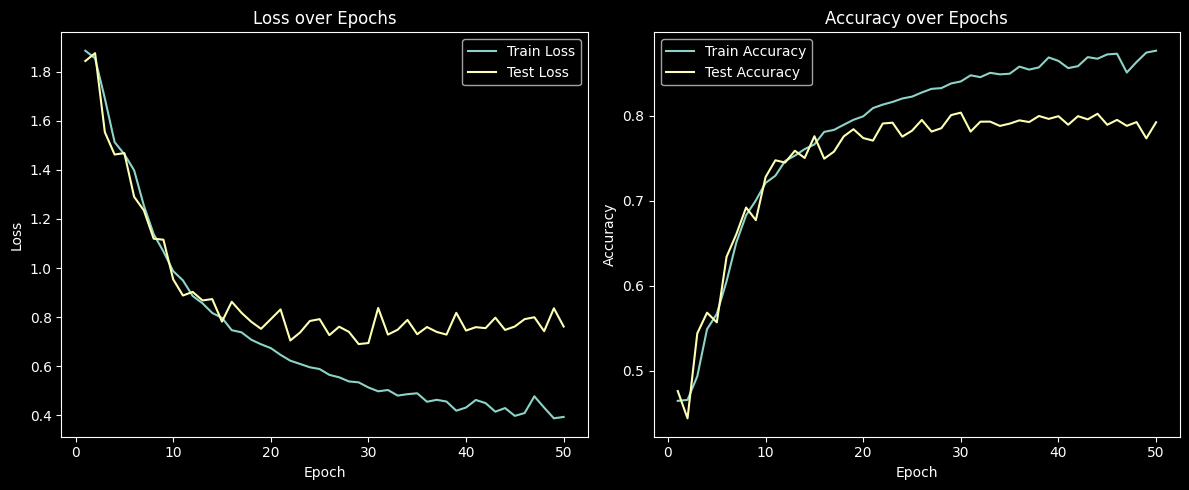

([1.884875286147889,
  1.8538580263753337,
  1.6907156280787343,
  1.5127074446573676,
  1.4633276980236707,
  1.3978783869410891,
  1.253887358295965,
  1.1383448417680673,
  1.0676541970189348,
  0.9876510470036967,
  0.9496566214528217,
  0.8862013462411455,
  0.8567054603560512,
  0.8171794019431707,
  0.7972030437503203,
  0.7469840753244689,
  0.7382738294295106,
  0.7081507620999062,
  0.6895986568939638,
  0.6740676618489136,
  0.6465853575275714,
  0.6227428846625218,
  0.6096247230096167,
  0.5959957950262434,
  0.5888142814021187,
  0.5650243406662665,
  0.555148644009197,
  0.5384396082346895,
  0.5346471867653954,
  0.5137558217898783,
  0.4981426388708006,
  0.5034158848433855,
  0.4806623668725272,
  0.4864897376661044,
  0.49012076042859676,
  0.4556059922087952,
  0.46356306744524206,
  0.4564801100270444,
  0.41922394784382616,
  0.432004281056236,
  0.4629351929780022,
  0.45017111247620617,
  0.41513415972193873,
  0.42989546456095945,
  0.3981003202794795,
  0.4095

In [79]:
train_and_test(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=50, device=device)

In [80]:
model_1 = SimpleRNN(input_size=N_CHARS,
                  hidden_units=128,
                  output_size=dataset.num_categories()).to(device)
model_1

SimpleRNN(
  (i2h): Linear(in_features=58, out_features=128, bias=True)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
)

Epoch 1/50
Test Loss 2.827594425943163 Accuracy 0.01488095238095238
Epoch 1: Train Loss 2.8280 Acc 0.0179 | Test Loss 2.8276 Acc 0.0149
Epoch 2/50
Test Loss 2.827594425943163 Accuracy 0.01488095238095238
Epoch 2: Train Loss 2.8282 Acc 0.0173 | Test Loss 2.8276 Acc 0.0149
Epoch 3/50
Test Loss 2.827594425943163 Accuracy 0.01488095238095238
Epoch 3: Train Loss 2.8280 Acc 0.0176 | Test Loss 2.8276 Acc 0.0149
Epoch 4/50
Test Loss 2.827594425943163 Accuracy 0.01488095238095238
Epoch 4: Train Loss 2.8280 Acc 0.0172 | Test Loss 2.8276 Acc 0.0149
Epoch 5/50
Test Loss 2.827594425943163 Accuracy 0.01488095238095238
Epoch 5: Train Loss 2.8281 Acc 0.0176 | Test Loss 2.8276 Acc 0.0149
Epoch 6/50
Test Loss 2.827594425943163 Accuracy 0.01488095238095238
Epoch 6: Train Loss 2.8280 Acc 0.0177 | Test Loss 2.8276 Acc 0.0149
Epoch 7/50
Test Loss 2.827594425943163 Accuracy 0.01488095238095238
Epoch 7: Train Loss 2.8281 Acc 0.0171 | Test Loss 2.8276 Acc 0.0149
Epoch 8/50
Test Loss 2.827594425943163 Accuracy 

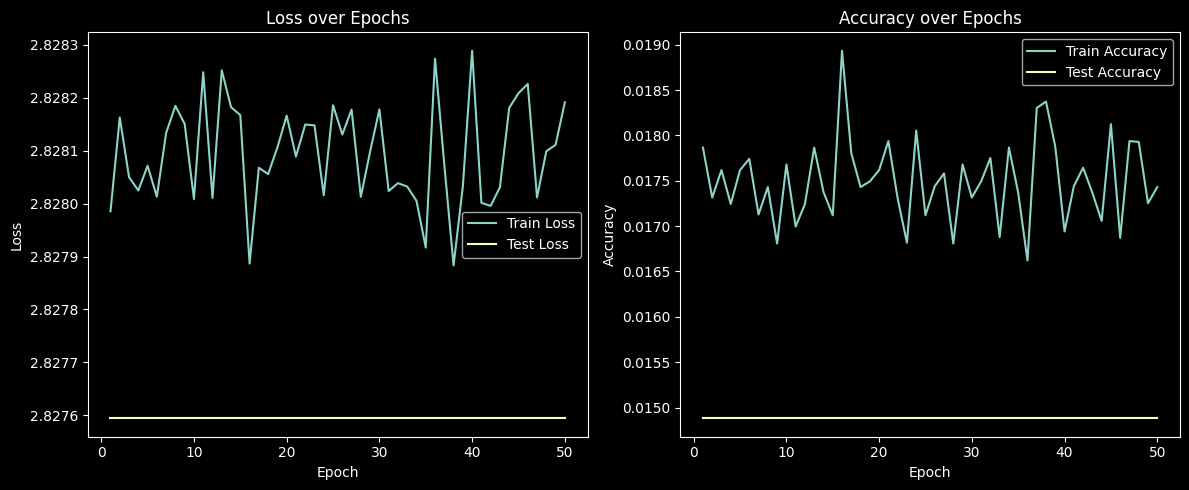

([2.8279853403805735,
  2.828162661586625,
  2.82804978511248,
  2.8280247250401165,
  2.82807140758788,
  2.8280130083342474,
  2.8281333726715756,
  2.8281844697625513,
  2.8281504195999814,
  2.8280084541594364,
  2.828248000239946,
  2.8280105096885406,
  2.828251473457215,
  2.8281820437822685,
  2.828166986366667,
  2.8278866502868225,
  2.828067598589863,
  2.828055562726055,
  2.828105885669055,
  2.8281659885231716,
  2.828088738053918,
  2.8281492469795197,
  2.8281476872850697,
  2.8280156717832345,
  2.828185705074751,
  2.8281302722801724,
  2.8281774767841474,
  2.8280127699156683,
  2.82809840540487,
  2.8281778125648955,
  2.828023659280572,
  2.8280385309956464,
  2.828032106992258,
  2.8280051134497044,
  2.827916861530319,
  2.8282736245379505,
  2.8280734393701135,
  2.827883315751277,
  2.8280322342754833,
  2.828288619261814,
  2.8280014184366657,
  2.827995586680226,
  2.828030863131185,
  2.8281806265690412,
  2.8282084161066914,
  2.828225856758209,
  2.8280114

In [82]:
train_and_test(model_1, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=50, device=device)

In [83]:
model("Goyal")

TypeError: SimpleRNN.forward() missing 1 required positional argument: 'hidden_state'